In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 4.129921459235217
(0, 5)
(5, 6)
(6, 11)
(11, 16)
(16, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [5]:
from dataset import optDatasetConstrs
# get training and test data set
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test) # without binding constr

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 502.00it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 880.91it/s]


In [6]:
# get training and test data set without feat & costs
dataset_train = optDatasetConstrs(optmodel, dataset_train.sols, sols=dataset_train.sols) # with binding constr
dataset_test = pyepo.data.dataset.optDataset(optmodel, dataset_test.sols, costs=c_test) # without binding constr

Obtaining constraints for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 740.06it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 770.62it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        num_var = (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0]
        self.linear = nn.Linear(num_var, num_var)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Learning Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot(range(0, num_epochs+1, log_step), regret_log, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
    plt.xticks(range(0, num_epochs+1, log_step), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.title("Learning Curve on Test Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time
def train(reg, ca_cos, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init log
    loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
    # running time
    elapsed = 0
    for epoch in range(num_epochs):
        tick = time.time()
        for data in loader_train:
            x, w, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = ca_cos(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
        # record time
        tock = time.time()
        elapsed += tock - tick
        if (epoch+1) % log_step == 1:
            # regret
            regret = pyepo.metric.regret(reg, optmodel, loader_test)
            regret_log.append(regret)
            print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
    print("Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log

### Exact Method 

In [11]:
# init model
reg = LinearRegression()

In [12]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel)

In [13]:
lr = 5e-3
num_epochs = 20
log_step = 2
loss_log, regret_log = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -1.0000, Regret:  1.4929%
Epoch   2, Loss:  -1.0000, Regret:  0.0870%
Epoch   4, Loss:  -1.0000, Regret:  0.0870%
Epoch   6, Loss:  -1.0000, Regret:  0.0870%
Epoch   8, Loss:  -1.0000, Regret:  0.0643%
Epoch  10, Loss:  -1.0000, Regret:  0.0153%
Epoch  12, Loss:  -1.0000, Regret:  0.0153%
Epoch  14, Loss:  -1.0000, Regret:  0.0153%
Epoch  16, Loss:  -1.0000, Regret:  0.0153%
Epoch  18, Loss:  -1.0000, Regret:  0.0153%
Elapsed Time: 1804.69 Sec


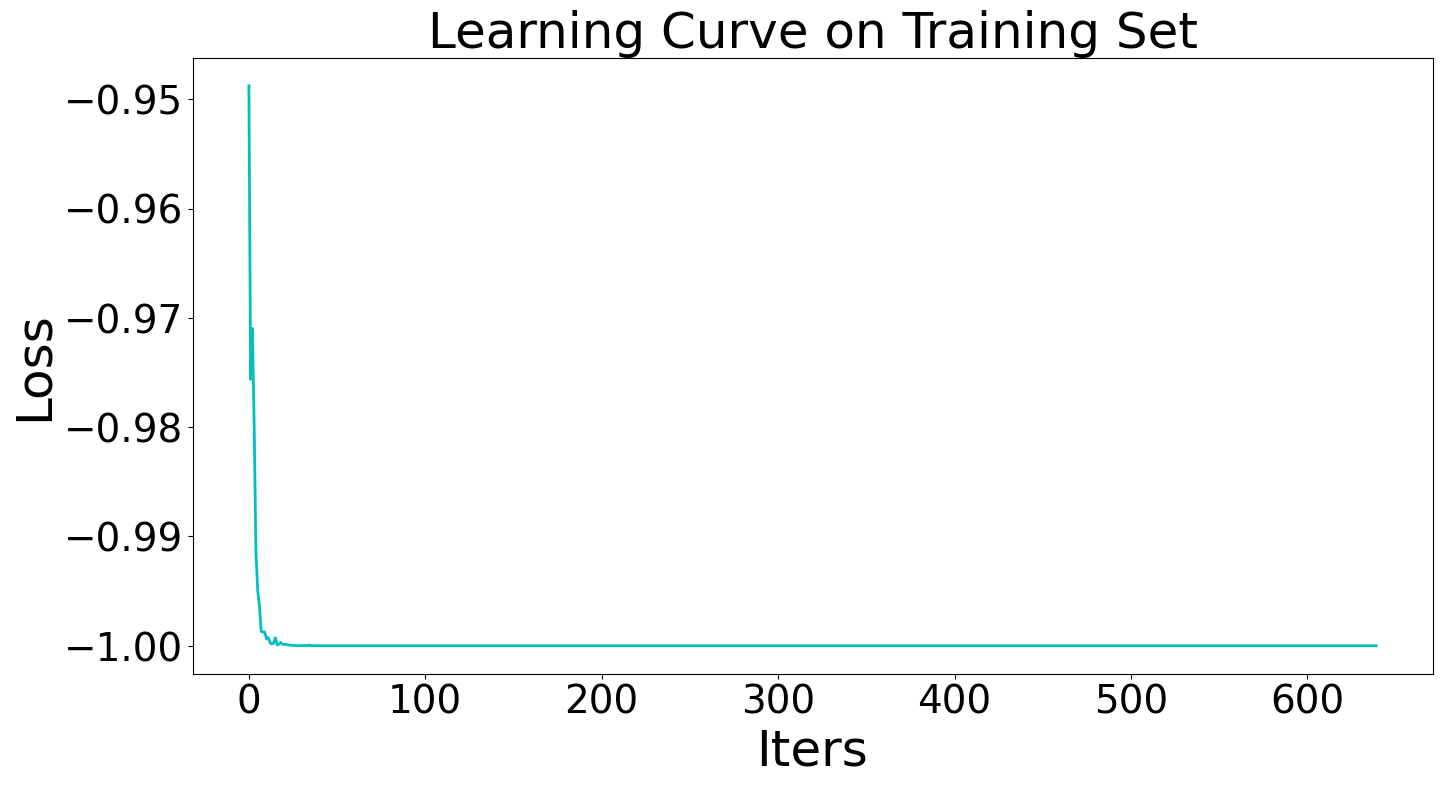

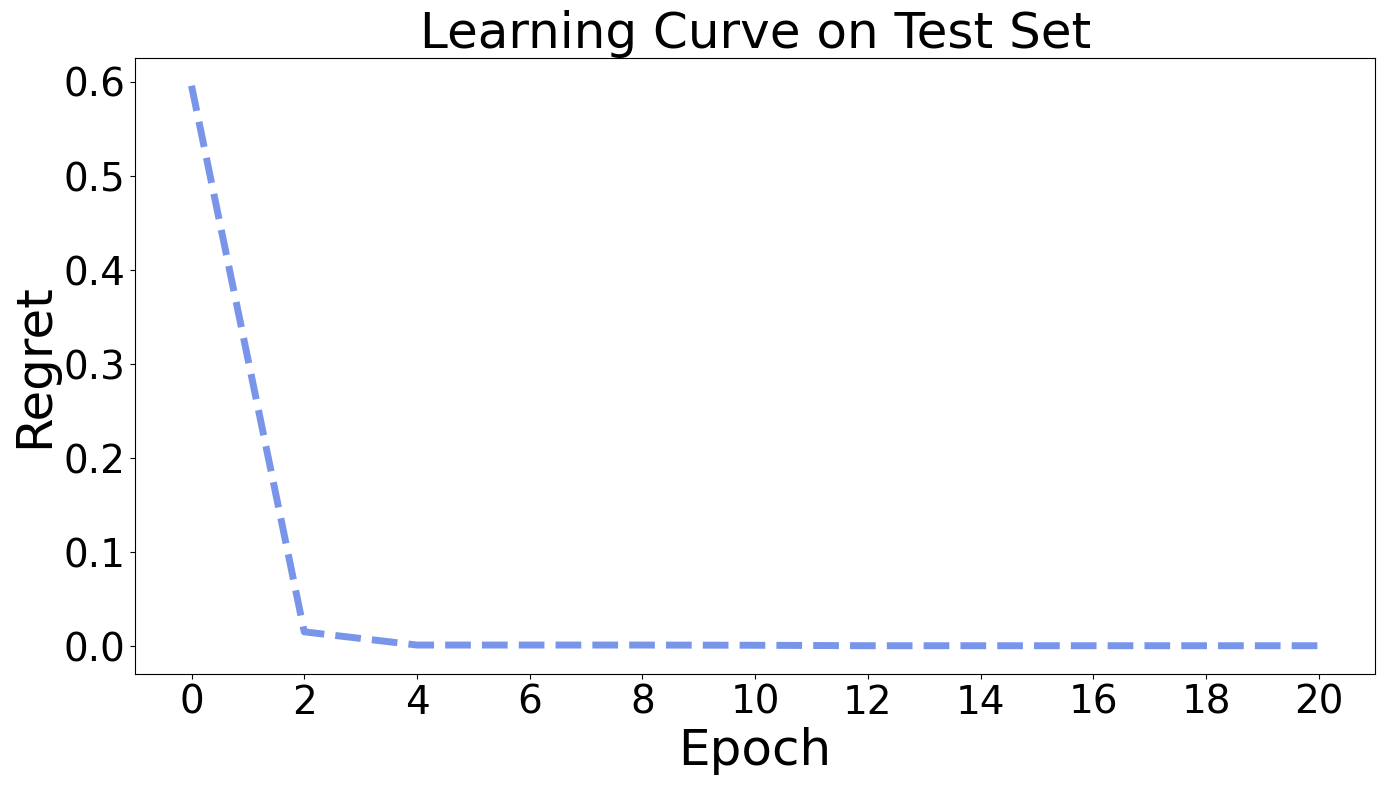

In [14]:
plot(loss_log, regret_log, num_epochs, log_step)

###  Base Vector Method

In [15]:
# init model
reg = LinearRegression()

In [16]:
from func import baseVectConeAlignedCosine
# init loss
ca_cos = baseVectConeAlignedCosine(optmodel)

In [17]:
lr = 5e-3
num_epochs = 20
log_step = 2
loss_log, regret_log = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9526, Regret: 48.1685%
Epoch   2, Loss:  -0.9725, Regret: 62.5672%
Epoch   4, Loss:  -0.9929, Regret: 61.1092%
Epoch   6, Loss:  -0.9905, Regret: 57.3849%
Epoch   8, Loss:  -0.9875, Regret: 57.5610%
Epoch  10, Loss:  -0.9972, Regret: 53.1522%
Epoch  12, Loss:  -0.9638, Regret: 56.9711%
Epoch  14, Loss:  -0.9960, Regret: 55.3562%
Epoch  16, Loss:  -0.9943, Regret: 64.0759%
Epoch  18, Loss:  -0.9842, Regret: 57.3527%
Elapsed Time: 1.25 Sec


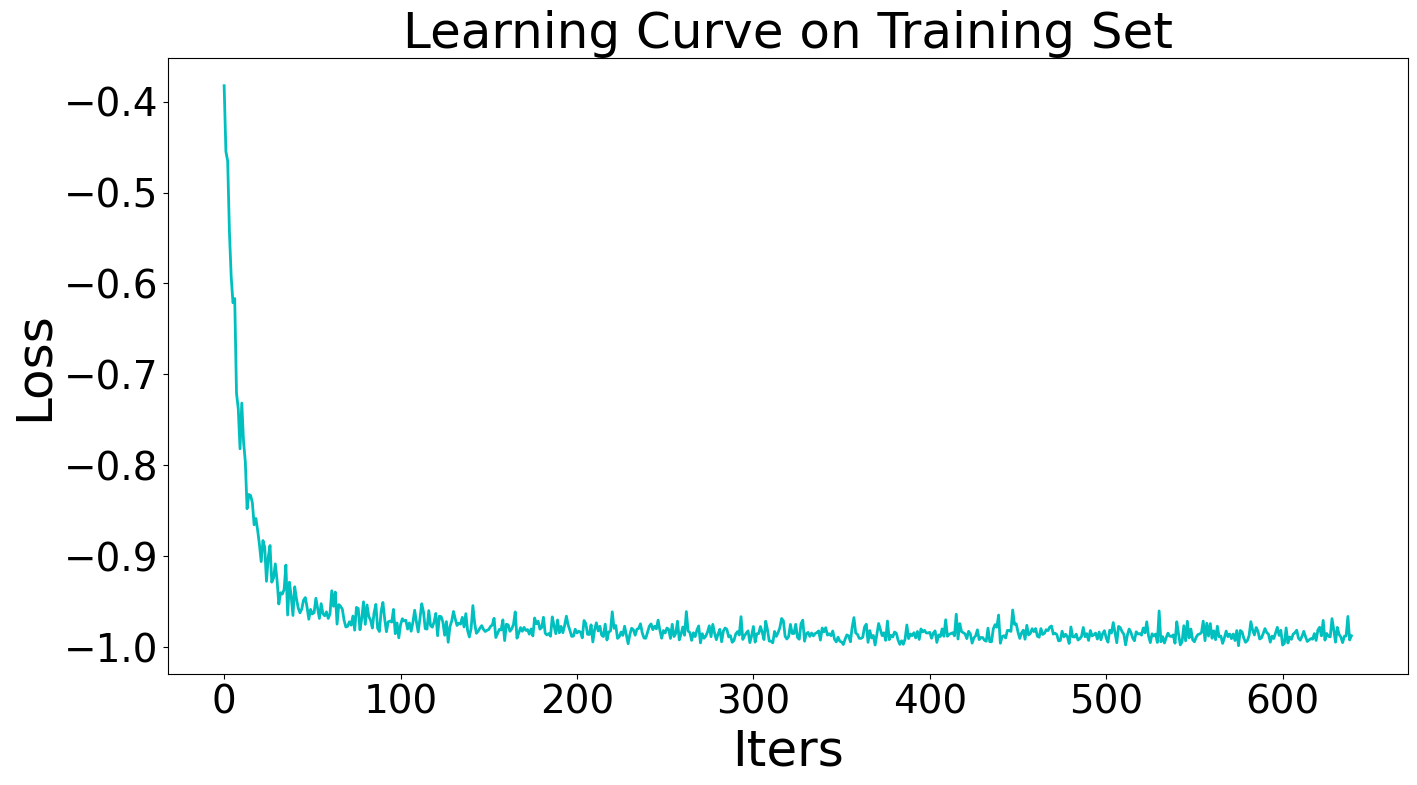

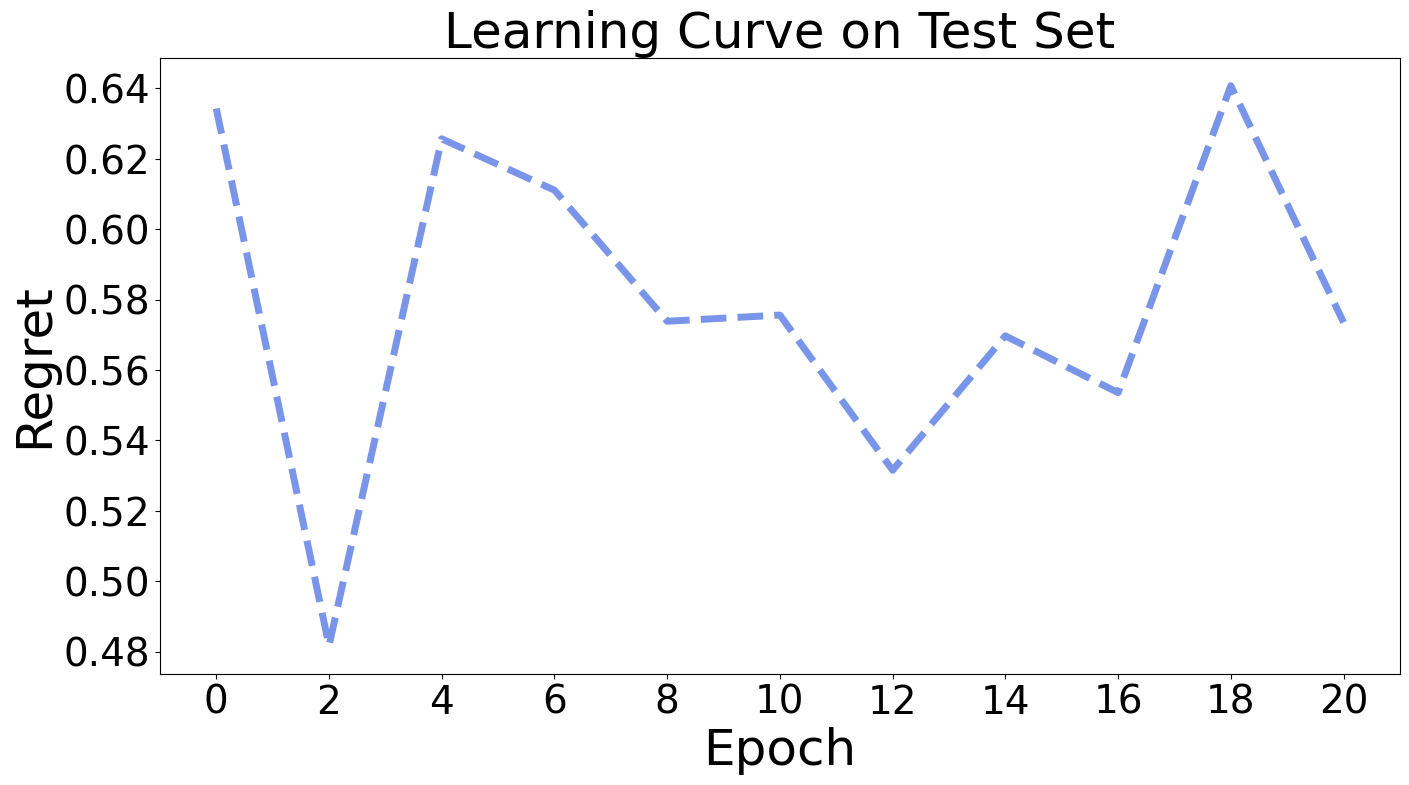

In [18]:
plot(loss_log, regret_log, num_epochs, log_step)

### Sampling Method

In [19]:
# init model
reg = LinearRegression()

In [20]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [21]:
lr = 5e-3
num_epochs = 20
log_step = 2
loss_log, regret_log = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.7619, Regret:  1.0544%
Epoch   2, Loss:  -0.7653, Regret: -0.0000%
Epoch   4, Loss:  -0.7792, Regret: -0.0000%
Epoch   6, Loss:  -0.7922, Regret: -0.0000%
Epoch   8, Loss:  -0.7823, Regret: -0.0000%
Epoch  10, Loss:  -0.7706, Regret: -0.0000%
Epoch  12, Loss:  -0.7932, Regret: -0.0000%
Epoch  14, Loss:  -0.7918, Regret: -0.0000%
Epoch  16, Loss:  -0.7875, Regret: -0.0000%
Epoch  18, Loss:  -0.7921, Regret: -0.0000%
Elapsed Time: 4.47 Sec


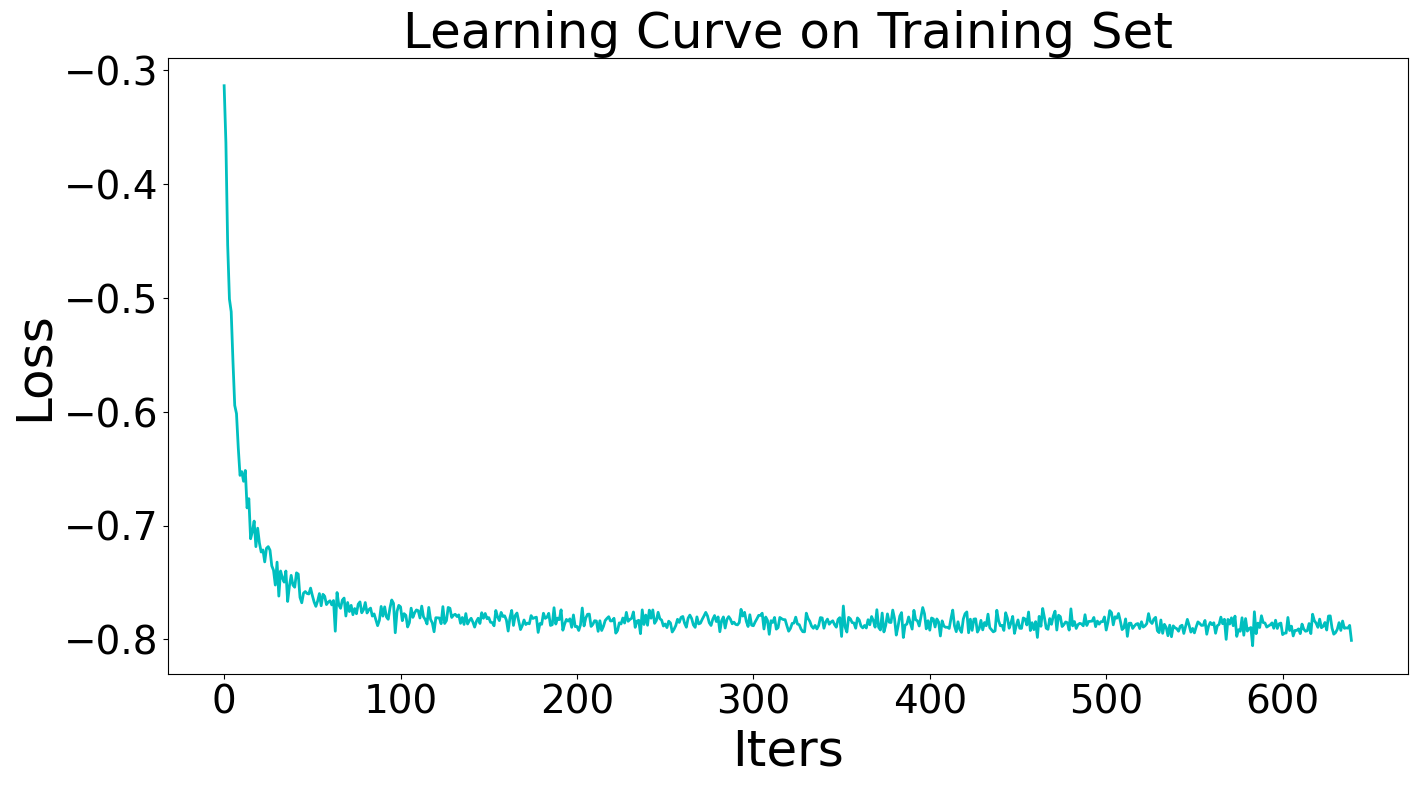

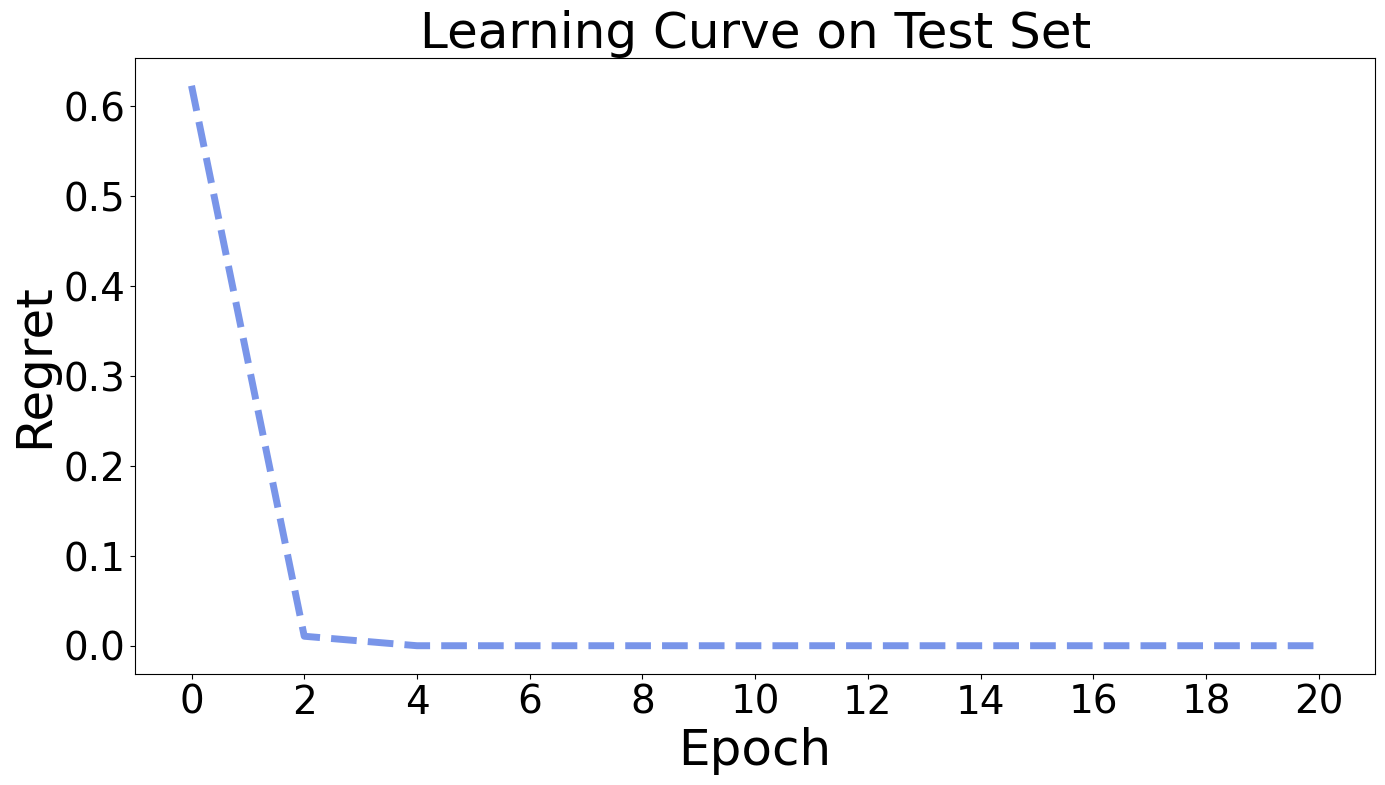

In [22]:
plot(loss_log, regret_log, num_epochs, log_step)